<a href="https://colab.research.google.com/github/Jayz2000/Binder_SAR_Hazards_Floods/blob/main/Final_Precipitation_Time_Series_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating NLDAS Precipitation Time-Series Plots using Python

### Overview

This notebook describes accessing GES DISC NLDAS data using Python. It queries
NLDAS total precipitation data from GES DISC OPeNDAP servers with the goal of
plotting flooding that occurred near Newton, IL in 2022.

### Prerequisites

This notebook was written using Python 3.9, and uses these libraries and files:

- [Matplotlib](https://matplotlib.org/)
- [earthaccess](https://github.com/nsidc/earthaccess)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [netCDF4-python](https://unidata.github.io/netcdf4-python/) (Version 1.6.2 or later, with libnetcdf >=4.9.3 or <=4.9.0)
- [Xarray](https://docs.xarray.dev/en/stable/)


### Install modules not included in Colab

In [ ]:
! pip install earthaccess h5pyd netcdf4 cartopy

### 1. Import modules

In [ ]:
import requests
import earthaccess
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import urllib
import urllib.parse as urlp
import io
import os
import platform
from subprocess import Popen
import warnings
import xarray as xr
import cmr
warnings.filterwarnings("ignore")

%matplotlib inline

## 2. Create Earthdata Login "Prerequisite" Files

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file. See https://github.com/nsidc/earthaccess for more details.

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username: cbattisto
Enter your Earthdata password: ··········
Persisting credentials to .netrc


Next, run the following code to generate the `.dodsrc` file, if it is not already present:

In [ ]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux
Popen('chmod og-rw ~/.netrc', shell=True)

Saved .dodsrc to: /root/


<Popen: returncode: None args: 'chmod og-rw ~/.netrc'>

*Optional:* Output the contents of your .netrc file to verify that your username/password are correct:

In [ ]:
! cat ~/.netrc

If your username and/or password are incorrect, use the following command to delete the `.netrc` file before restarting your runtime using Runtime -> Restart Session.

For safety, I've commented-out the cell so that the file is not accidentally removed.

In [ ]:
# ! rm ~/.netrc

### 3. Query Granules from the Content Metadata Repository

Next, we will query the Content Metadata Repository (CMR) API to generate a list of OPeNDAP URLsfor the NLDAS granules that fall under the specified time range.

To explore the metadata of the granule, and to make subsets manually, you can append ".html" to the end of the OPeNDAP URL and click on it to view the DAP Request Form. Here is what the first URL looks like: https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0000.020.nc.html



In [ ]:
# Empty list for URLs to be appended to
opendap_links = []

# Initialize the CMR search API
api = cmr.GranuleQuery()

# Define the time range
start_time = "2022-08-01T00:00:00Z"
end_time = "2022-08-05T23:59:59Z"

# Search for granules with the specific short name, version, time range, and bounding box
granules = (
    api.short_name('NLDAS_FORA0125_H')
    .temporal(start_time, end_time)
    .get_all()
)

# Output the granules and their links
for granule in granules:
    opendap_link = None
    http_link = None
    # Find OPeNDAP links
    for link in granule.get('links', []):
        if 'href' in link:
            href = link['href']
            if 'opendap' in href and '.nc' in href:
                opendap_link = href
                opendap_links.append(opendap_link)

print("Granules Found: ", len(opendap_links))

Granules Found:  120


Now, lets add the longitude, latitude, and total precipitation variables that we wish to subset through OPeNDAP to the URLs.

**Note:** This step is not necessary, but it will greatly reduce the loading times for the following Xarray step, since there are lots of variables and metadata in each NLDAS granule.

In [ ]:
# Empty list for the OPeNDAP URLs with appended variables
opendap_link_subsets = []

for link in opendap_links:
  opendap_link_subsets.append(link + '?lon,lat,time,Rainf')

print(opendap_link_subsets)

['https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0000.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0100.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0200.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0300.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0400.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0500.020.nc?lon,lat,time,Rainf', 'https://hydro1.gesdisc.eosdis.nasa.gov/opendap/NLDAS/NLDAS_FORA0125_H.2.0/2022/213/NLDAS_FORA0125_H.A20220801.0600.020.nc?lon,lat,time

### 4. Open the links as a single `Xarray` Dataset

Here, we will use Xarray's `open_mfdataset()` command to open the list of OPeNDAP URLs as a single Xarray dataset object along the time dimension, and create 120 time "steps". This is essentially a 4-dimensional array, where the "time" dimension represents each individual OPeNDAP granule.

In [ ]:
ds = xr.open_mfdataset(opendap_link_subsets)
ds

<xarray.Dataset>
Dimensions:  (lon: 464, lat: 224, time: 120)
Coordinates:
  * lon      (lon) float32 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float32 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * time     (time) datetime64[ns] 2022-08-01 ... 2022-08-05T23:00:00
Data variables:
    Rainf    (time, lat, lon) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

### 5. Use `sel()` to select the lat/lon point that we want to sum

This query will return the nearest point of the closest grid, which is at 38.94, -88.19 (southwest of Newton, IL):

https://maps.app.goo.gl/JYsXt7FQYG1BWm3F7

Note that doing this removes the lat/lon dimensions from the dataset, leaving us with the 'time' dimension that we will create a plot along.

In [ ]:
point_subset = ds.sel(lat=38.93, lon=-88.18, method='nearest')
point_subset

<xarray.Dataset>
Dimensions:  (time: 120)
Coordinates:
    lon      float32 -88.19
    lat      float32 38.94
  * time     (time) datetime64[ns] 2022-08-01 ... 2022-08-05T23:00:00
Data variables:
    Rainf    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

### 6. Resample and calculate daily sums using `resample()` and `sum()`

`Xarray` has the ability to resample and sum across various time subsets, like days, months, and even years. Here, we will calculate the daily sums, which will be stored in individual day steps (*Remember that a "day" in this case is measured between 00Z-23Z*).

Remember to convert our units to cm by multiplying each value by 0.1, according to the following formula (presented in LaTeX!):

$\text{cm} = \frac{\left( \text{kg/m}^2 \right) \times \left( 1000 \text{ cm}^3/\text{L} \right)}{10000 \text{ cm}^2/\text{m}^2}$

Note that the 'time' dimension now has a length of 5, representing days, instead of hours.

In [ ]:
point_sum = point_subset.resample(time='1D').sum() * 0.1 # convert to cm
point_sum

<xarray.Dataset>
Dimensions:  (time: 5)
Coordinates:
    lon      float32 -88.19
    lat      float32 38.94
  * time     (time) datetime64[ns] 2022-08-01 2022-08-02 ... 2022-08-05
Data variables:
    Rainf    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

### 7. Plot the daily sums using built-in Matplotlib routines

Xarray will automagically create line plots for 1-dimensional data arrays, like we have here, when we call `plot()`.

Text(0, 0.5, 'Total Precipitation (cm)')

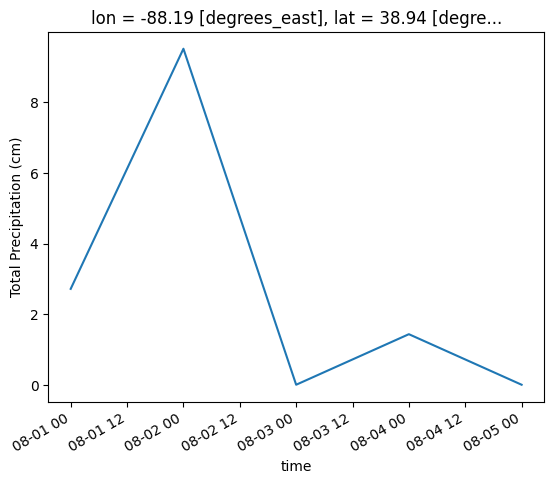

In [ ]:
point_sum['Rainf'].plot()
plt.ylabel('Total Precipitation (cm)')

### 8. Select area for  sums using `sum()`

We will select slices over the southern portion of Illinois/Missouri, before we compute the sum:

In [ ]:
area_subset = ds.sel(lat=slice(38, 41), lon=slice(-91, -87.5))
area_subset

<xarray.Dataset>
Dimensions:  (lon: 28, lat: 24, time: 120)
Coordinates:
  * lon      (lon) float32 -90.94 -90.81 -90.69 -90.56 ... -87.81 -87.69 -87.56
  * lat      (lat) float32 38.06 38.19 38.31 38.44 ... 40.56 40.69 40.81 40.94
  * time     (time) datetime64[ns] 2022-08-01 ... 2022-08-05T23:00:00
Data variables:
    Rainf    (time, lat, lon) float32 dask.array<chunksize=(1, 24, 28), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

### 6. Compute the total, hourly sum

Remember to convert units again!


In [ ]:
area_sum = area_subset['Rainf'].sum(dim='time') * 0.1 # convert to cm
area_sum

<xarray.DataArray 'Rainf' (lat: 24, lon: 28)>
dask.array<mul, shape=(24, 28), dtype=float32, chunksize=(24, 28), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -90.94 -90.81 -90.69 -90.56 ... -87.81 -87.69 -87.56
  * lat      (lat) float32 38.06 38.19 38.31 38.44 ... 40.56 40.69 40.81 40.94

### 7. Plot a map using Cartopy and Matplotlib

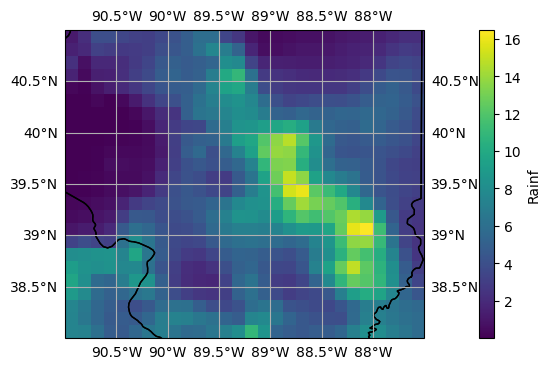

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Create a Cartopy map
fig = plt.figure(figsize=(14, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the summed 'Rainf' variable
area_sum.plot(ax=ax, transform=ccrs.PlateCarree())

# Add map features like coastlines, gridlines, etc.
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.STATES)

# Show the plot
plt.show()
